In [28]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP, FCLIPDataset
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [34]:
from __future__ import annotations

import requests
import os
import json
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor

from PIL import Image
from matplotlib import pyplot as plt
import faiss
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [35]:
data_path = '/Users/jsb/repos/moodboard/data/asos/all_products_8799.json'

download from "https://github.com/patrickjohncyh/gradient-recs.git"

In [30]:
cd gradient-recs
cd app

In [31]:
from gradient_rec import GradREC
cd ../..

In [36]:
import json

with open(data_path, 'r') as fp:
    products = json.loads(fp.readline())

In [37]:
def images_to_embeddings(images: list[Image]) -> torch.tensor:
    """"""
    vembeds = fclip.encode_images(images)

    vembeds = vembeds / vembeds.norm(p=2, dim=-1, keepdim=True)
    
    return vembeds

In [44]:
class AsosClothingDataset(Dataset):
    """
    dataset found at https://data.world/promptcloud/amazon-fashion-products-2020/file/marketing_sample_for_amazon_com-amazon_fashion_products__20200201_20200430__30k_data.ldjson
    downloads dataset images fast with multithreading, and includes 
    category-specific subsetting for fast recommendation over a category
    """
    @staticmethod
    def read_records(fpath):
        records = []
        with open(fpath, 'r') as fp:
            for line in fp:
                records.append(json.loads(line))
        return records
    
    def _download(self, record):
        """download a single record"""
        md = None
        try:
            image_url = "https://" + record["imageUrl"]
            image_path = os.path.join(self.image_dir, str(record["id"]) + ".jpg")
            if not os.path.exists(image_path):
                image = Image.open(requests.get(image_url, stream=True).raw)
                image.save(image_path)

            # label = f"a catalog photo of {record['name']}"
            label = record['name']
            
            category = "dress"

            md = {
                "product_id": record["id"],
                "image_path": image_path,
                "image_url": image_url,
                "label": label,
                "category": category,
            }
        except:
            print('failed')
            md = None

        return md

    @staticmethod
    def _thread_run(f, my_iter):
        """download all records using multithreading"""
        with ThreadPoolExecutor() as executor:
            results = list(tqdm(executor.map(f, my_iter), total=len(my_iter)))
        return results


    def __init__(self, image_dir: str, records: List[dict]):
        
        ids = [rec["id"] for rec in records]
        
        self.image_dir = image_dir
        
        os.makedirs(self.image_dir, exist_ok=True)
        
        # download images and return metadata
#         mds = []
#         for record in records:
#             md = self._download(record)
#             mds.append(md)
        
        mds = self._thread_run(self._download, records)
        mds = [md for md in mds if md is not None]
    
        self.metadata = pd.DataFrame(mds)
        self.metadata.set_index("product_id")
        self.metadata.sort_index()
        self.metadata.reset_index(drop=True)
        
    def __getitem__(self, idx: int) -> (Image, str, str):
        md = self.metadata.iloc[idx]
        
        try:
            image_path = md.image_path
        except:
            image_path = None

        return (image_path, md.label, md.category)
    
    def __len__(self,) -> int:
        return len(self.metadata)
    
    
    def get_category_indices(self, category: str) -> np.array:
        """return the indices of all products in this category"""
        md = self.metadata[self.metadata.category == category]
        return md.index

In [45]:
image_dir = "./TEST"

records = products

asos_dataset = AsosClothingDataset(image_dir=image_dir, records=records)

100%|█████████████████████████████████| 19545/19545 [00:00<00:00, 131616.19it/s]


In [46]:
catalog = []
for irow, row in asos_dataset.metadata.iterrows():
    md = {'id': irow, 'image': row.image_path, 'caption': row.label}
    catalog.append(md)

In [48]:
fclip_dataset = FCLIPDataset(
    'asos_local', 
    image_source_path='.',
    image_source_type='local',
    catalog=catalog)

In [50]:
fclip = FashionCLIP('fashion-clip', fclip_dataset)

611it [04:53,  2.08it/s]                                                        


Map:   0%|          | 0/19545 [00:00<?, ? examples/s]

611it [03:25,  2.98it/s]                                                        


Normalizing Input Vectors...Done!
Building Approx NN index...Done!


In [51]:
gradrec = GradREC(fclip)

In [83]:
# Supply a start and end query to obtain semantic direction of traversal
start_query = 'miami'
end_query = 'matrix'
v_dir = gradrec.direction_vector(
    start_query=start_query,
    end_query=end_query,
)

Map:   0%|          | 0/132 [00:00<?, ? examples/s]

5it [00:01,  3.25it/s]                                                          


In [84]:
start_points = fclip.retrieval([start_query])

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 19.11it/s]


In [93]:
path = gradrec.traverse_space(start_point=fclip.image_vectors[start_points[0][1]],
                              search_space=fclip.image_vectors,
                              v_dir=v_dir,
                              step_size=-2.0,
                              steps=10,
                              reg_space=fclip.image_vectors,
                              reg_weight=0.8,
                              k=3,
                             )

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 330.36it/s]


In [94]:
path = [[fclip_dataset.ids[idx] for idx in p] for p in path]

In [95]:
path

[['2998', '4636', '16374'],
 ['2998', '6438', '15399'],
 ['11340', '552', '2124'],
 ['8532', '11340', '626'],
 ['2236', '6822', '4089'],
 ['4089', '6822', '1124'],
 ['4089', '1124', '6951'],
 ['1124', '4089', '6951'],
 ['1124', '8775', '4697'],
 ['4697', '7452', '1124'],
 ['4697', '7452', '1124']]

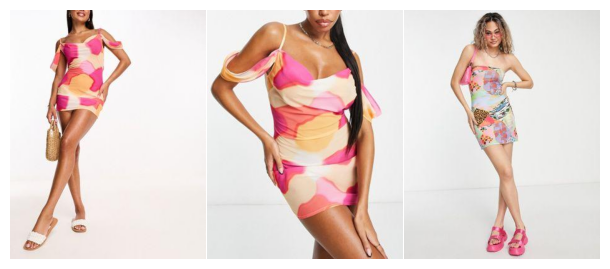

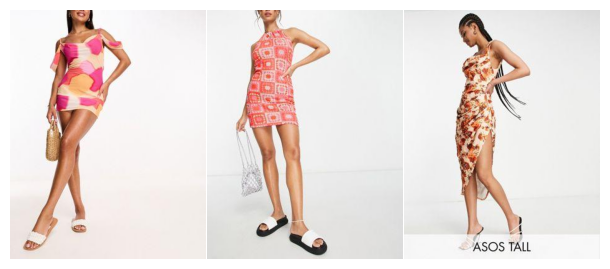

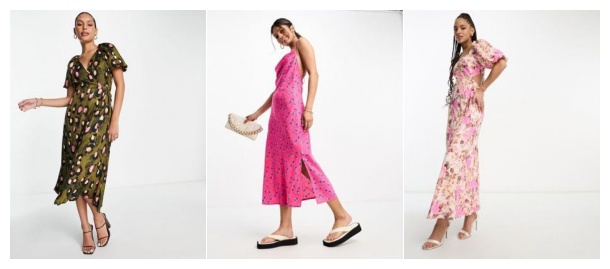

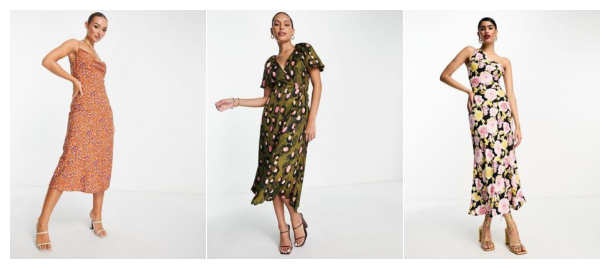

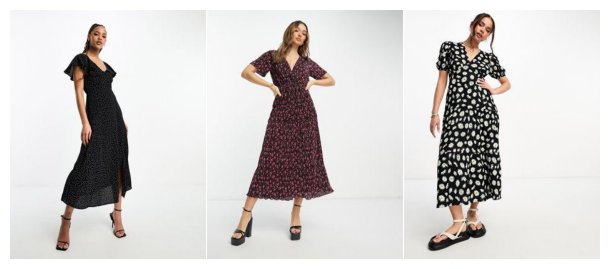

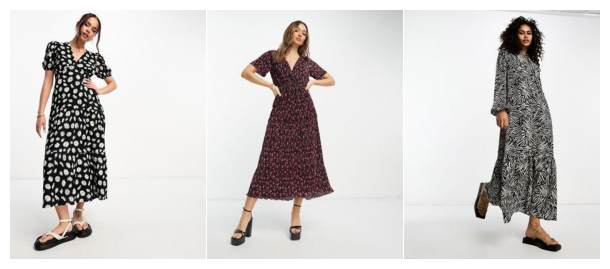

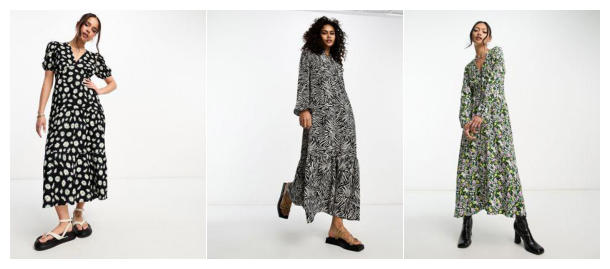

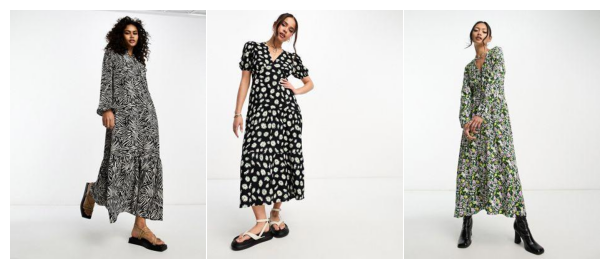

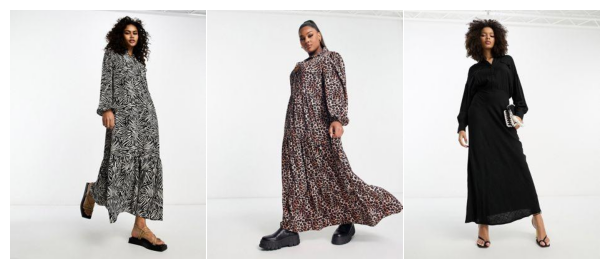

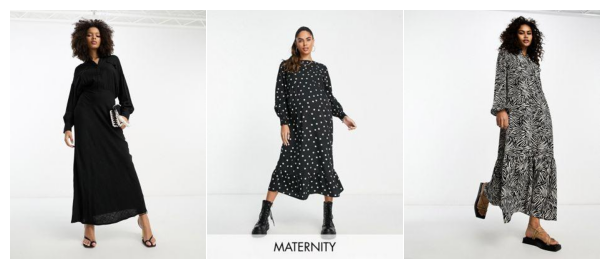

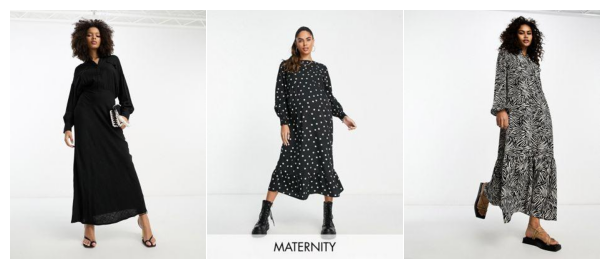

In [96]:
for p in path:
    fclip_dataset.display_products(p, fields=tuple(), columns=10)